<a href="https://colab.research.google.com/github/gadilshina-ve/BDP_MGPU/blob/main/Pr_5_%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D0%B4%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_PySpark/Pr_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Инициализация платформы Spark и загрузка данных в фрейм данных Spark** <a class="anchor" id="1"></a>

**Гадильшина ВЕ, БД-231м**

Источник данных: https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset?select=brewery_data_complete_extended.csv


В этом наборе данных представлена обширная подборка данных пивоварни по производству крафтового пива за период с января 2020 по январь 2024 года. Он включает в себя богатую комбинацию параметров пивоварения, данных о продажах и оценок качества, обеспечивая целостное представление о процессе пивоварения и его влиянии на рынок.

In [2]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ls

drive/  sample_data/


In [5]:
!mkdir pyspark2024

In [6]:
ls

drive/  pyspark2024/  sample_data/


In [7]:
cd pyspark2024

/content/pyspark2024


In [8]:
!unzip "/content/drive/MyDrive/Colab Notebooks GadilshinaVE/BDP/brewery_data_complete.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks GadilshinaVE/BDP/brewery_data_complete.zip
  inflating: brewery_data_complete_extended.csv  


In [9]:
ls

brewery_data_complete_extended.csv


In [10]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=51368e6d92151611a38e0c1ad1d2feed1e42db08c13fa505c773b50d604f753c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [11]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '10G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'brewery_data_complete_extended.csv' # Загрузите данные в текущий каталог Colab.
# filename_data = 'data/endomondoHR.json' # Загрузите данные в каталог data/  при работе в Docker.
# Загрузите основной набор данных в фрейм данных pyspark.
#df = spark.read.csv(filename_data, mode="DROPMALFORMED")
df = spark.read.csv(filename_data, header=True, inferSchema=True, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Обзор набора данных** <a class="anchor" id="2"></a>

### Схема, столбцы и типы данных набора:
   *Набор данных содержит столбцы с одним значением (int, string, timestamp)

In [ ]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

Обзор столбцов


,Column Name,Data type
0,Batch_ID,int
1,Brew_Date,timestamp
2,Beer_Style,string
3,SKU,string
4,Location,string
5,Fermentation_Time,int
6,Temperature,double
7,pH_Level,double
8,Gravity,double
9,Alcohol_Content,double


In [ ]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()

Описание фрейма данных (только строковые и числовые столбцы):


,summary,Batch_ID,Beer_Style,SKU,Location,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Ingredient_Ratio,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
0,count,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000
1,mean,4999999.5,None,None,None,14.500898,19.999898511018827,4.999940543893489,1.0550028700788692,5.249709006579308,39.4961996,11.9993459,None,2749.0309594,10497.785343940232,7.999825148192516,80.00091934182497,3.000081497042524,3.000002413212497,3.0001587106749747
2,stddev,2886751.4902856858,None,None,None,2.872006096518228,2.8870297120328576,0.28863762894103545,0.014434649211836703,0.43296144791729213,11.545572488490313,4.321170228005893,None,1299.078133259011,5485.995544804044,1.1546793056214646,5.7749295785811645,1.1547483756083143,1.1548266863212513,1.1547186092997934
3,min,0,Ale,Bottles,Electronic City,10,15.000001163771435,4.500000005935603,1.0300000027891478,4.500000235642255,20,5,1:0.20:0.10,500,1000.0009630942443,6.000000644037316,70.00000702282782,1.000000399567285,1.0000008690556794,1.0000002095815321
4,max,9999999,Wheat Beer,Pints,Yelahanka,19,24.999998289887966,5.499999818305633,1.0799999980323736,5.999999932506248,59,19,1:0.50:0.30,4999,19999.99964105241,9.999998860537378,89.99999982126904,4.999999841589812,4.999999816405875,4.999999721589095


In [ ]:
print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(5).toPandas()

Общее количество 10000000 строк, печатаем несколько первых строк:


,Batch_ID,Brew_Date,Beer_Style,SKU,Location,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Ingredient_Ratio,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
0,7870796,2020-01-01 00:00:19,Wheat Beer,Kegs,Whitefield,16,24.204251,5.289845,1.039504,5.370842,20,5,1:0.32:0.16,4666,2664.759345,8.577016,89.195882,4.104988,3.235485,4.663204
1,9810411,2020-01-01 00:00:31,Sour,Kegs,Whitefield,13,18.086763,5.275643,1.059819,5.096053,36,14,1:0.39:0.24,832,9758.801062,7.420541,72.480915,2.676528,4.246129,2.044358
2,2623342,2020-01-01 00:00:40,Wheat Beer,Kegs,Malleswaram,12,15.539333,4.778016,1.037476,4.824737,30,10,1:0.35:0.16,2115,11721.087016,8.451365,86.322144,3.299894,3.109440,3.033880
3,8114651,2020-01-01 00:01:37,Ale,Kegs,Rajajinagar,17,16.418489,5.345261,1.052431,5.509243,48,18,1:0.35:0.15,3173,12050.177463,9.671859,83.094940,2.136055,4.634254,1.489889
4,4579587,2020-01-01 00:01:43,Stout,Cans,Marathahalli,18,19.144908,4.861854,1.054296,5.133625,57,13,1:0.46:0.11,4449,5515.077465,7.895334,88.625833,4.491724,2.183389,2.990630


# **3. Обнаружение пропущенных значений и аномальных нулей.** <a class="anchor" id="3"></a>

После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.

- Для строковых столбцов  проверяем наличие `None` и `null`.
- Для числовых столбцов проверяем наличие нулей и `NaN`.


In [ ]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,Batch_ID,int
1,Brew_Date,timestamp
2,Beer_Style,string
3,SKU,string
4,Location,string
5,Fermentation_Time,int
6,Temperature,double
7,pH_Level,double
8,Gravity,double
9,Alcohol_Content,double


In [ ]:
string_columns = ['Beer_Style', 'SKU', 'Location', 'Ingredient_Ratio']
numeric_columns = ['Batch_ID', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging']

In [ ]:
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Batch_ID,Beer_Style,SKU,Location,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Ingredient_Ratio,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **4. Ленивая оценка Pyspark** <a class="anchor" id="4"></a>

Здесь мы начнем знакомиться с некоторыми функциями продвинутого `Spark`: **Ленивая оценка**.

<font color="red"><b>Ленивая оценка</b></font> расширяет возможности Apache Spark за счет сокращения времени выполнения операций RDD. Он поддерживает граф происхождения для запоминания операций над RDD. мы можем просто помнить, что вся обработка в Pyspark — это абстракция. Когда мы хотим вернуть результаты, мы на самом деле сообщаем Spark, какой конечный ответ вас интересует, и он определяет лучший способ получить его. В результате это оптимизирует производительность и обеспечивает отказоустойчивость.

Чтобы увидеть результат, нам нужно вызвать `Spark.collect()`.

Обычно можем показать результаты с помощью синтаксиса: `df.take(k)` или `df.limit(k)`, чтобы получить результаты с `k`-строкой.

Когда `K` становится большим числом, выполнение этих двух способов, описанных выше, занимает много времени. Потому что приведенный выше синтаксис не использовал возможности обработки `Pyspark` (ленивая оценка).
Чтобы быстро обработать, требуется использовать `df.collect()[:k]` для возврата строки `k`, которая нам требуется.

Подробнее о ленивых вычислениях `Pyspark` можно прочитать в статье : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [ ]:
from pyspark.sql.functions import sum

# Группировка данных по видам пива и подсчет общей суммы продаж для каждого вида
sales_by_beer_style_df = df.groupBy("Beer_Style").agg(sum("Total_Sales").alias("Total Sales")) \
                           .orderBy("Total Sales", ascending=False)

# Получение топ-5 видов пива по общей сумме продаж
top_5_beer_styles_df = sales_by_beer_style_df.limit(5).toPandas()

# Подсчет общей суммы продаж. Это потребуется для вычисления процентного соотношения.
total_sales_style = sales_by_beer_style_df.groupBy().sum().collect()[0][0]

In [ ]:
sales_by_beer_style_df.collect()[:5]

[Row(Beer_Style='Ale', Total Sales=13146382710.681017),
 Row(Beer_Style='Porter', Total Sales=13130512026.054022),
 Row(Beer_Style='Sour', Total Sales=13125541866.495354),
 Row(Beer_Style='Pilsner', Total Sales=13122350032.703396),
 Row(Beer_Style='Lager', Total Sales=13117665386.547726)]

In [ ]:
from pyspark.sql.functions import sum

# Группировка данных по районам города и подсчет общей суммы продаж для каждого района
sales_by_beer_location_df = df.groupBy("Location").agg(sum("Total_Sales").alias("Total Sales")) \
                           .orderBy("Total Sales", ascending=False)

# Получение топ-5 районов города по общей сумме продаж
top_5_beer_location_df = sales_by_beer_location_df.limit(5).toPandas()

# Подсчет общей суммы продаж. Это потребуется для вычисления процентного соотношения.
total_sales_location = sales_by_beer_location_df.groupBy().sum().collect()[0][0]

In [ ]:
sales_by_beer_location_df.collect()[:5]

[Row(Location='HSR Layout', Total Sales=10513877980.859257),
 Row(Location='Rajajinagar', Total Sales=10505038100.602842),
 Row(Location='Jayanagar', Total Sales=10504795345.53082),
 Row(Location='Marathahalli', Total Sales=10500764080.72577),
 Row(Location='Yelahanka', Total Sales=10499633412.411142)]

# **5. Исследовательский анализ данных** <a class="anchor" id="5"></a>

Давайте сначала составим таблицу, указав 5 лучших видов пива по сумме продаж, которые мы оценили выше.

In [ ]:
# Переименуем исходный DataFrame
highest_beer_styles_df_renamed = top_5_beer_styles_df

# Вычислим процент пяти самых популярных видов пива от общей суммы продаж
highest_beer_styles_df_renamed['percentage'] = highest_beer_styles_df_renamed['Total Sales'] \
    / total_sales_style * 100

# Определим остальные виды пива как "others"
others = {
    'Beer_Style': 'others',
    'Total Sales': total_sales_style - highest_beer_styles_df_renamed['Total Sales'].sum(),
    'percentage': 100 - highest_beer_styles_df_renamed['percentage'].sum()
}

# Добавим строку для "others" в топ-5 DataFrame
highest_beer_styles_df_renamed = highest_beer_styles_df_renamed._append(others, ignore_index=True
)

print('Топ-5 видов пива по общей сумме продаж:')
highest_beer_styles_df_renamed

Топ-5 видов пива по общей сумме продаж:


,Beer_Style,Total Sales,percentage
0,Ale,1.314638e+10,12.523006
1,Porter,1.313051e+10,12.507888
2,Sour,1.312554e+10,12.503153
3,Pilsner,1.312235e+10,12.500113
4,Lager,1.311767e+10,12.495650
5,others,3.933540e+10,37.470190


Составим таблицу, указав 5 самых пьющих районов города по сумме продаж, которые мы оценили выше.

In [ ]:
# Переименуем исходный DataFrame
highest_beer_location_df_renamed = top_5_beer_location_df

# Вычислим процент пяти самых пьющих районов города от общей суммы продаж
highest_beer_location_df_renamed['percentage'] = highest_beer_location_df_renamed['Total Sales'] \
    / total_sales_location * 100

# Определим остальные районы города как "others"
others = {
    'Location': 'others',
    'Total Sales': total_sales_location - highest_beer_location_df_renamed['Total Sales'].sum(),
    'percentage': 100 - highest_beer_location_df_renamed['percentage'].sum()
}

# Добавим строку для "others" в топ-5 DataFrame
highest_beer_location_df_renamed = highest_beer_location_df_renamed._append(others, ignore_index=True
)

print('Топ-5 районов города по общей сумме продаж:')
highest_beer_location_df_renamed

Топ-5 районов города по общей сумме продаж:


,Location,Total Sales,percentage
0,HSR Layout,1.051388e+10,10.015330
1,Rajajinagar,1.050504e+10,10.006909
2,Jayanagar,1.050480e+10,10.006678
3,Marathahalli,1.050076e+10,10.002837
4,Yelahanka,1.049963e+10,10.001760
5,others,5.245374e+10,49.966486


Построим диаграмму для процентного распределения продаж по видам пива:

<ipython-input-24-c056cf8d4500>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_beer_styles_df_renamed['Beer_Style']


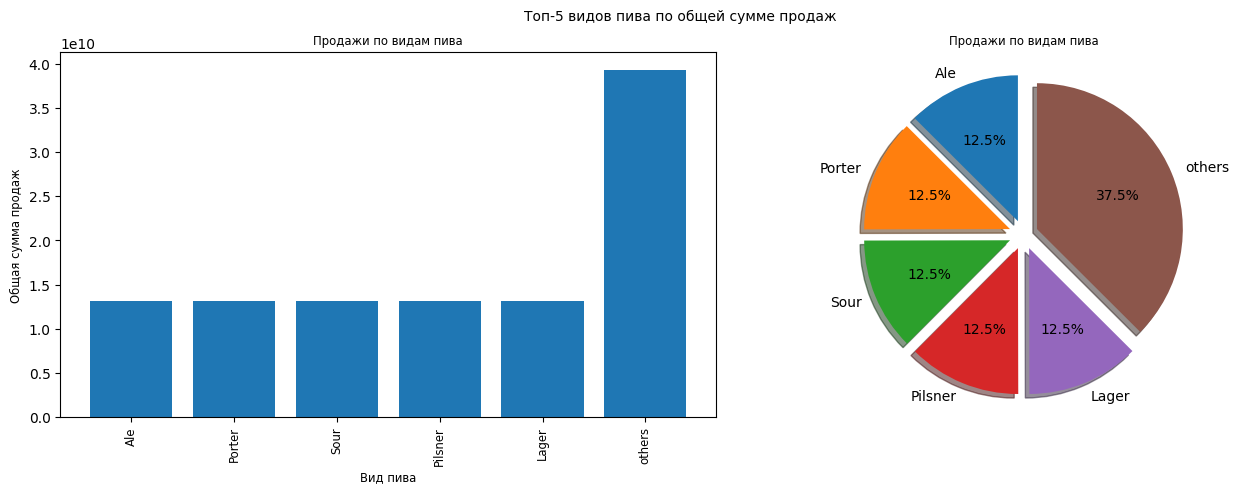

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

# Построение столбчатой диаграммы для количества продаж каждого вида пива
plot0 = axs[0].bar(x=highest_beer_styles_df_renamed['Beer_Style']
                     , height=highest_beer_styles_df_renamed['Total Sales'])
title0 = axs[0].set_title('Продажи по видам пива', fontsize='small')
xlabel0 = axs[0].set_xlabel('Вид пива', fontsize='small')
ylabel0 = axs[0].set_ylabel('Общая сумма продаж', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_beer_styles_df_renamed['Beer_Style']
                                       , rotation='vertical', fontsize='small')

# Построение круговой диаграммы для процентного распределения продаж по видам пива
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # чтобы выделить секторы
title1 = axs[1].set_title('Продажи по видам пива', fontsize='small')
plot1 = axs[1].pie(
      x=highest_beer_styles_df_renamed['percentage']
    , labels=highest_beer_styles_df_renamed['Beer_Style']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

# Добавление общего заголовка
text = fig.text(0.5, 1.02, 'Топ-5 видов пива по общей сумме продаж', ha='center', va='top', transform=fig.transFigure)

plt.tight_layout()
plt.show()

Данные показывают, что жители города Бангалор (Индия) покупали пиво вида Lager, Ale, Porter, Sour, Pilsner в равном соотношении.

<ipython-input-25-fb4ad315deba>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_beer_location_df_renamed['Location']


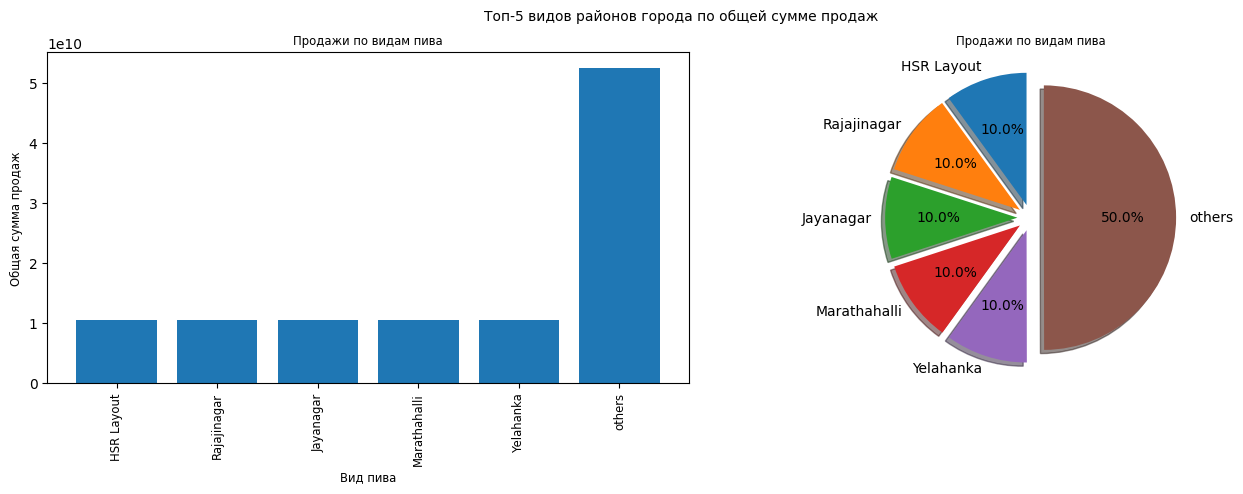

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

# Построение столбчатой диаграммы для количества продаж для каждого района города
plot0 = axs[0].bar(x=highest_beer_location_df_renamed['Location']
                     , height=highest_beer_location_df_renamed['Total Sales'])
title0 = axs[0].set_title('Продажи по видам пива', fontsize='small')
xlabel0 = axs[0].set_xlabel('Вид пива', fontsize='small')
ylabel0 = axs[0].set_ylabel('Общая сумма продаж', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_beer_location_df_renamed['Location']
                                       , rotation='vertical', fontsize='small')

# Построение круговой диаграммы для процентного распределения продаж по районам
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # чтобы выделить секторы
title1 = axs[1].set_title('Продажи по видам пива', fontsize='small')
plot1 = axs[1].pie(
      x=highest_beer_location_df_renamed['percentage']
    , labels=highest_beer_location_df_renamed['Location']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

# Добавление общего заголовка
text = fig.text(0.5, 1.02, 'Топ-5 видов районов города по общей сумме продаж', ha='center', va='top', transform=fig.transFigure)

plt.tight_layout()
plt.show()

Данные показывают, что жители города Бангалор (Индия) покупали пиво в районах HSR Layout, Rajajinagar, Jayanagar, Marathahalli, Yelahankaв в равном соотношении.

In [ ]:
# Просмотр данных по виду пива и месту продажи пива
beer_style_by_location = df.groupBy('Beer_Style', 'Location').count().toPandas()
beer_style_by_location[:5]

,Beer_Style,Location,count
0,Porter,Rajajinagar,124648
1,Stout,Marathahalli,124885
2,Ale,Rajajinagar,125196
3,Wheat Beer,Koramangala,124948
4,Porter,Electronic City,125293


# **6. UNSTACK PYSPARK DATAFRAME** <a class="anchor" id="5"></a>

Требуется изменить форму приведенной выше таблицы, чтобы разбить столбец локация продажи, для последующей визуализации.



Всего: 10000000 продаж в зависимости от локации:


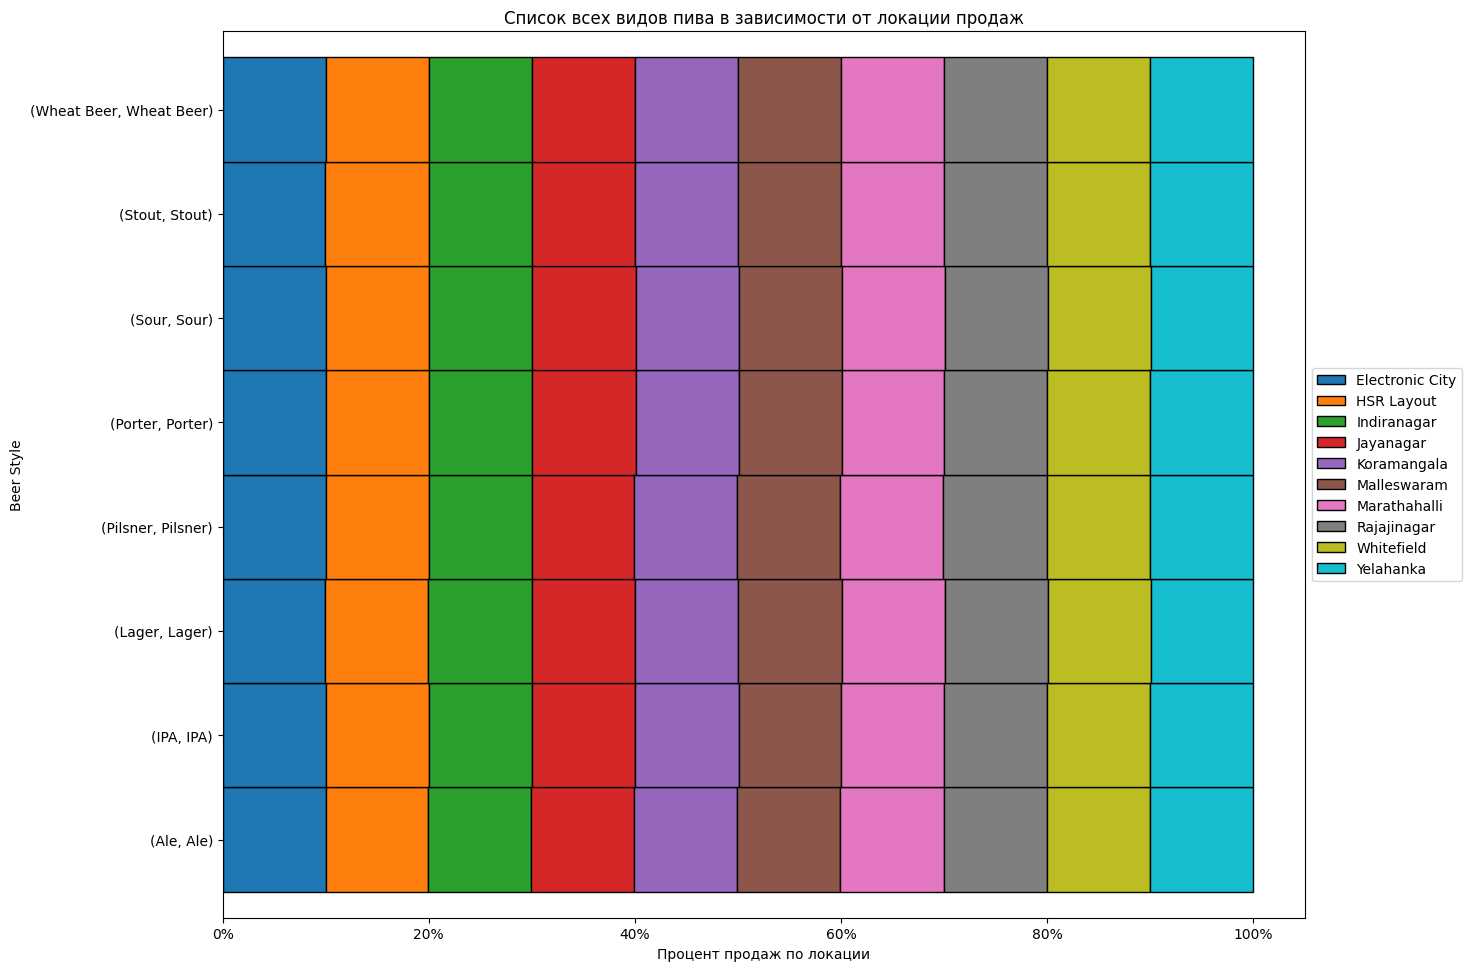

In [11]:
# Вывод общего количества продаж в зависимости от локации
total_sales = df.count()
print(f'Всего: {total_sales} продаж в зависимости от локации:')
beer_style_by_location = df.groupBy('Beer_Style', 'Location').count().toPandas()
# Визуализация
fig = plt.figure(figsize=(15, 10))
grid_size = (1, 1)
ax = plt.subplot2grid(grid_size, (0, 0), colspan=1, rowspan=1)
plot = beer_style_by_location.groupby(['Beer_Style', 'Location']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1, edgecolor='black', ax=ax,
                                   title='Список всех видов пива в зависимости от локации продаж')
ylabel = plt.ylabel('Beer Style')
xlabel = plt.xlabel('Процент продаж по локации')
legend = plt.legend(sorted(beer_style_by_location['Location'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5))

# Обновление параметров для надписей
param_update = plt.rcParams.update({'font.size': 16})
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter())
a = fig.tight_layout()
plt.show()

In [12]:
print('\nГрафик распределения продаж пива по районам :')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,6)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
Count_dist = df.select('Location', 'Beer_Style').toPandas().hist(
    column='Location', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='Beer_Style', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Распределение количества продаж пива по видам пива и районам', ha='center'
         , fontsize='small', transform=fig.transFigure);
xlabel = fig.text(
    0.5, 0.01, '# пиво/районы', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Частота (количество)', va='center', rotation='vertical');


График распределения продаж пива по районам :


<ipython-input-12-4f36abebc4ff>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  Count_dist = df.select('Location', 'Beer_Style').toPandas().hist(


# **7. Pyspark UDF** <a class="anchor" id="6"></a>

### Создание  новой функции
Создадим функции для рассчета общего объема потерь на всех этапах производства в процентах и в литрах **total_loss** и **loss_volume**

Чтобы прикрепить новую функции к `SparkdDataFrame`,  регистрируем их с помощью `PYSPARK UDF`.


In [33]:
from pyspark.sql.functions import col, lit, udf, expr
from pyspark.sql.types import DoubleType

In [34]:
# Функция для расчета общего объема потерь
def calculate_total_loss(brewing_loss, fermentation_loss, bottling_loss):
    total_loss = ((1 - brewing_loss / 100) *
                  (1 - fermentation_loss / 100) *
                  (1 - bottling_loss / 100))
    return total_loss

# Регистрация пользовательской функции (UDF)
calculate_total_loss_udf = udf(calculate_total_loss, DoubleType())

In [35]:
# Создание нового столбца total_loss для расчета общего объема потерь
df = df.withColumn('total_loss',
                   calculate_total_loss_udf(
                       col('Loss_During_Brewing'),
                       col('Loss_During_Fermentation'),
                       col('Loss_During_Bottling_Kegging')
                   )
                  )

In [42]:
# Функция для рассчета потеряного объема каждой партии пива
def calculate_loss_volume(Volume_Produced, total_loss):
    if total_loss >= 1:
        return None  # Нельзя делить на ноль, когда общий процент потерь равен или больше 100%
    return Volume_Produced / (100 - total_loss)

# Регистрация пользовательской функции (UDF)
calculate_loss_volume_udf = udf(calculate_loss_volume, DoubleType())

# Создание нового столбца loss_volume для расчета потеряного объема каждой партии пива в литрах
df = df.withColumn('loss_volume',
                   calculate_loss_volume_udf(
                       col('Volume_Produced'),
                       col('total_loss')
                   )
                  )

In [43]:
print('Новые столбцы (''total_loss'', ''loss_volume'')\n, first 5 rows:')
df.select('total_loss', 'loss_volume').limit(5).toPandas()

Новые столбцы (total_loss, loss_volume)
, first 5 rows:


,total_loss,loss_volume
0,0.884652,47.076463
1,0.912858,8.396650
2,0.908507,21.343911
3,0.919382,32.024427
4,0.906290,44.896896


### Теперь посмотрим на статистику по total_loss и loss_volume.

In [44]:
print('\nСтатистика потерь (в процентах):')
df.select('total_loss').toPandas().describe().T


Статистика потерь (в процентах):


,count,mean,std,min,25%,50%,75%,max
total_loss,10000000.0,0.912671,0.018819,0.85765,0.899303,0.912516,0.925859,0.969966


Из статистики столбца total_loss видно, что потери могут быть от 0.85765% до 0.969966%.

In [45]:
print('\nСтатистика потерь (в литрах):')
df.select('loss_volume').toPandas().describe().T


Статистика потерь (в литрах):


,count,mean,std,min,25%,50%,75%,max
loss_volume,10000000.0,27.743518,13.11044,5.043485,16.384405,27.74139,39.098986,50.477234


Из статистики столбца loss_volume видно, что потери могут быть от 5 л до 50,5 л.

Теперь пришло время построения графика потерь в литрах по видам пива:



Построение графика распределения потерь в литрах по видам пива:


<ipython-input-46-a1fb3ff05330>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  loss_volume_dist = df.select('loss_volume', 'Beer_Style').toPandas().hist(


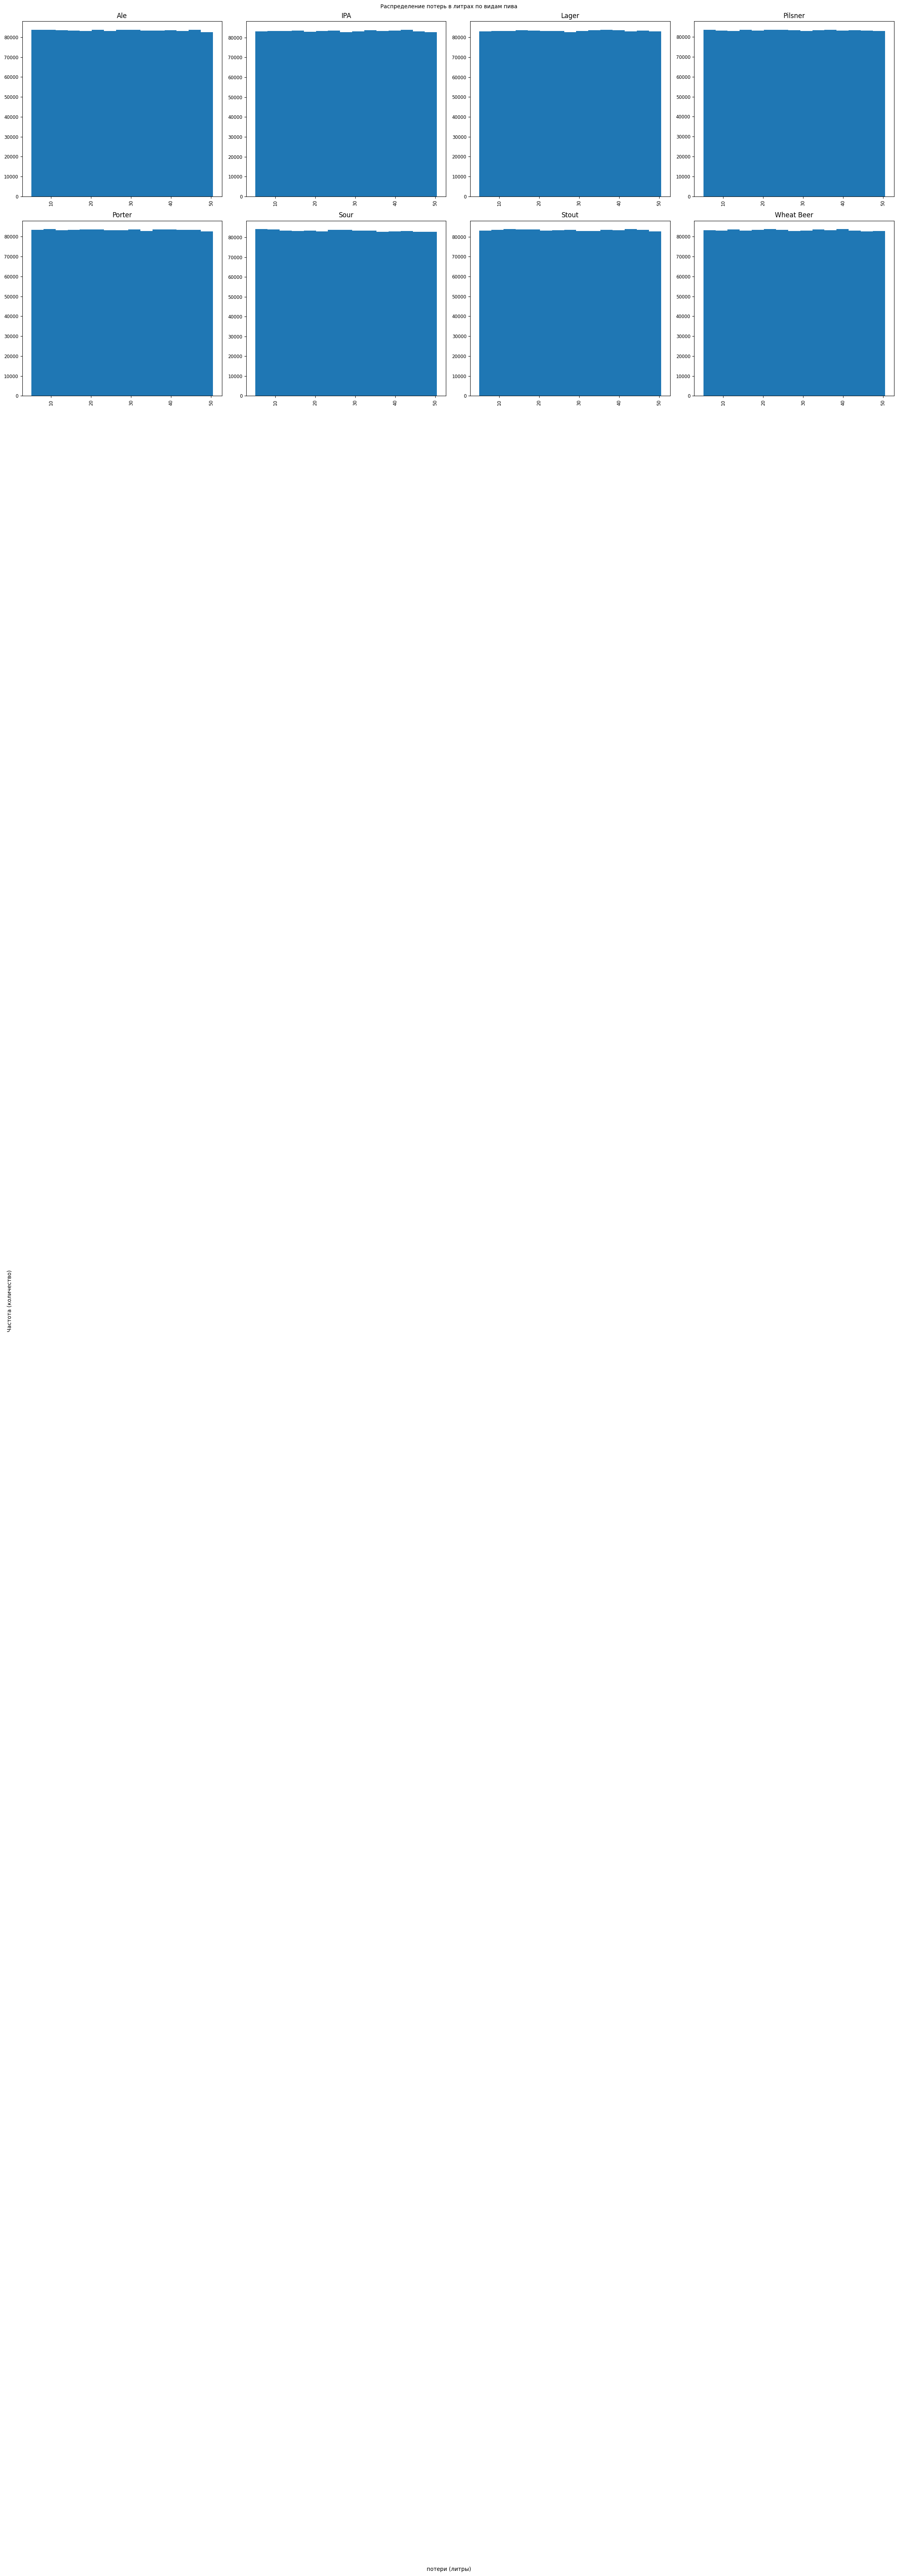

In [46]:

print('\nПостроение графика распределения потерь в литрах по видам пива:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
figsize = (figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

loss_volume_dist = df.select('loss_volume', 'Beer_Style').toPandas().hist(
    column='loss_volume', by='Beer_Style', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Распределение потерь в литрах по видам пива'
             , ha='center', va='center', transform=fig.transFigure
            )
xlabel = fig.text(0.5, 0.01, 'потери (литры)'
             , ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Частота (количество)', va='center', rotation='vertical');

* По графикам видно, что потери в литрах пропорционально растут от объема партии, аномалий не видно*

# **8.Преобразование объектов строк в устойчивый распределенный набор данных Spark (RDD)** <a class="anchor" id="7"></a>


На этом графике мы попрактикуемся в преобразовании объекта строки в формат RDD в Pyspark с помощью:

```python
rdd = df.rdd.map(tuple)
or
rdd = df.rdd.map(list)
```

`RDD` — очень важная концепция в `Spark`, можете углубиться в нее здесь:
https://www.educba.com/what-is-rdd/

Чтобы попрактиковаться в этой концепции,  посмотрим на столбец `loss_volume` и получим по нему некоторую статистику. Рассчитаем некоторые основные статистические данные (мин/макс/среднее/среднее/стандартное отклонение и 4 квантиля 25/50/75/95) в `pySpark`, преобразуем в Rdd и построим их на графике.



In [88]:
# Вспомогательная функция для расчета статистики имени столбца из кортежа x (Beer_Style, список записей столбца) tuple x of (Beer_Style, records list of the column)
# Статистика для расчета также предоставляется в качестве входных данных
def calculate_stats(x, column_name, stat_list):
    Beer_Style, records_list = x
    stat_dict = {'Beer_Style': Beer_Style}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def extend(a, b):
    if isinstance(b, list):
        a.extend(b)
    else:
        a.append(b)
    return a

# Основная функция для расчета статистики по определенному столбцу в DataFrame
def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Преобразование Beer_Style и «column_name» в RDD, чтобы легко рассчитать статистику интервалов по видам пива.
    beer_record_rdd = df.select('Beer_Style', column_name).rdd \
        .map(tuple).combineByKey(extend, extend).persist()

    # Вычислить статистику входного столбца, вызвав функцию calculate_stats, определенную выше.
    record_statistic_df = pd.DataFrame(
        beer_record_rdd.map(lambda x: calculate_stats(x, column_name, stat_list)).collect()
    )

    # Установка правильного порядка столбцов данных.
    columns_order = ['Beer_Style'] + [stat + ' ' + column_name for stat in stat_list]
    # Изменение порядка столбцов
    return record_statistic_df[columns_order]

# Список статистик для расчета
stat_list = ['min', '25th percentile', 'mean', '50th percentile',
             '75th percentile', '95th percentile', 'max', 'stdev']

# Вызов основной функции для расчета статистики
loss_volume_statistic_df = retrieve_array_column_stat_df(df, column_name='loss_volume', stat_list=stat_list)

In [89]:
# Вывод результатов
print('\nПросмотр статистики потерь в литрах (по виду пива)')
loss_volume_statistic_df


Просмотр статистики потерь в литрах (по виду пива)


,Beer_Style,min loss_volume,25th percentile loss_volume,mean loss_volume,50th percentile loss_volume,75th percentile loss_volume,95th percentile loss_volume,max loss_volume,stdev loss_volume
0,Porter,5.043660,16.376506,27.738697,27.737121,39.097212,48.182394,50.472718,13.112031
1,IPA,5.043860,16.394763,27.761839,27.763074,39.125100,48.185247,50.474185,13.111501
2,Stout,5.043622,16.369463,27.740387,27.725202,39.109320,48.180118,50.476225,13.112755
3,Wheat Beer,5.043806,16.400622,27.741918,27.732216,39.084314,48.178112,50.472281,13.102147
4,Pilsner,5.043977,16.396884,27.750330,27.747581,39.097475,48.193581,50.477023,13.110119
5,Sour,5.043616,16.346459,27.710124,27.693352,39.071357,48.177343,50.472503,13.115308
6,Lager,5.043485,16.409320,27.765810,27.787831,39.108845,48.188102,50.477234,13.109450
7,Ale,5.043774,16.381713,27.739069,27.743565,39.095938,48.177154,50.475160,13.110153


Теперь мы отображаем эти числа в виде столбцов (для статистики квантилей) и линейных диаграмм (для мин/макс/среднего/стандартного отклонения) для большей наглядности.
*Примечание. Поскольку максимальный интервал и стандартное отклонение имеют гораздо более высокий порядок величины по сравнению с остальными столбцами, нам нужно поместить эти два столбца на отдельную ось Y справа.*


Обобщенная статистика интервальных видов пива:


[Text(0, 0, 'Pilsner'),
 Text(1, 0, 'Lager'),
 Text(2, 0, 'IPA'),
 Text(3, 0, 'Porter'),
 Text(4, 0, 'Stout'),
 Text(5, 0, 'Wheat Beer'),
 Text(6, 0, 'Sour'),
 Text(7, 0, 'Ale')]

Text(0.5, 0, 'Вид пива')

Text(0, 0.5, 'Статистика квантилей + мин/среднее\n(литров)')

Text(0, 0.5, 'Max/stdev Statistics\n(liters)')

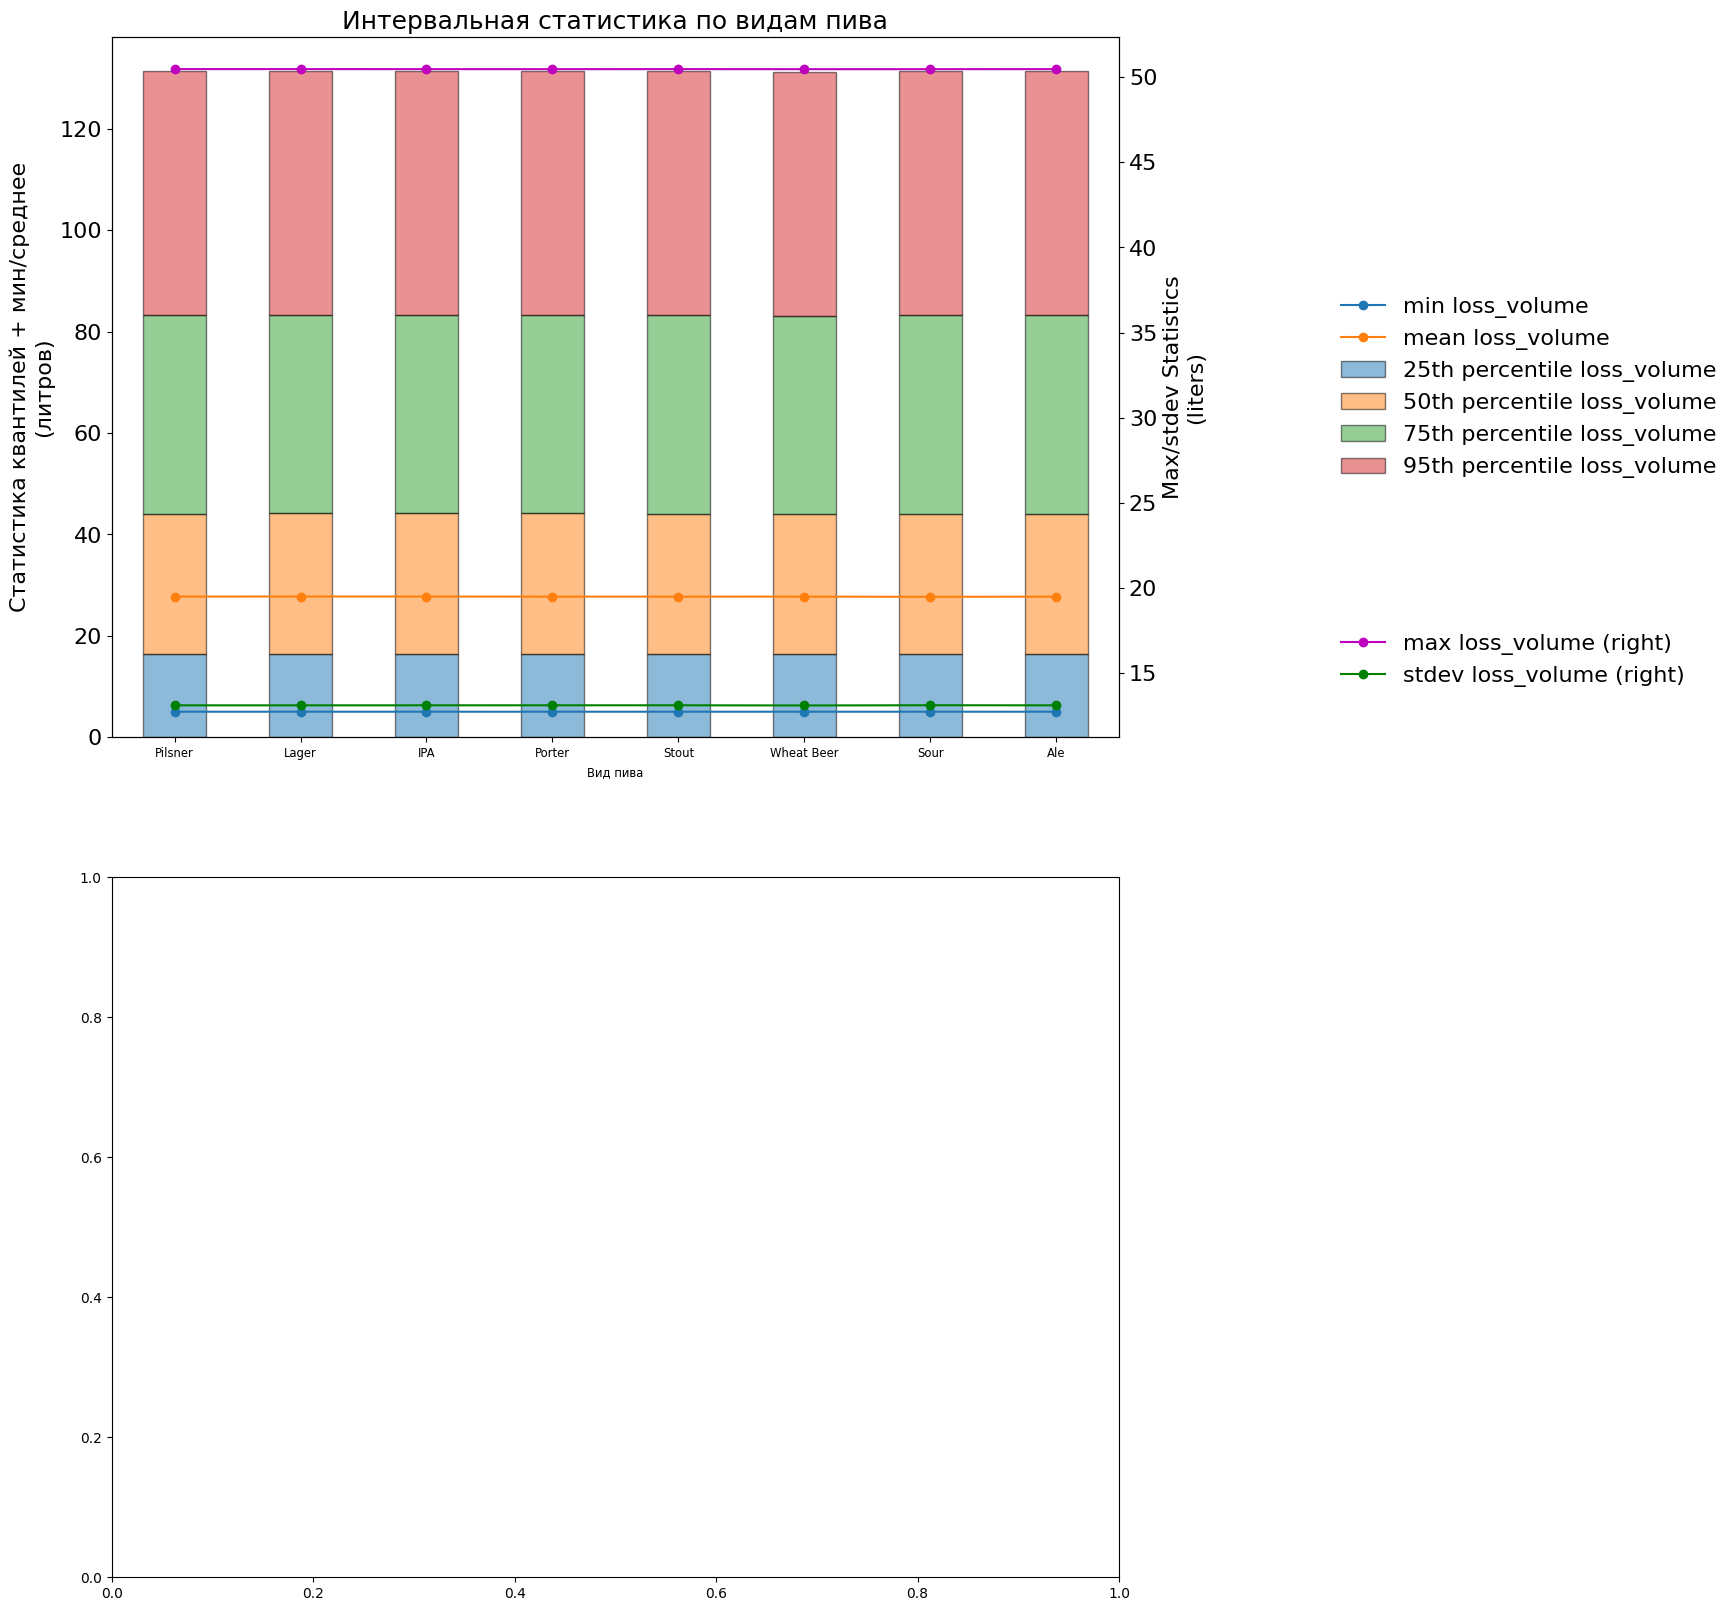

In [122]:
print('\nОбобщенная статистика интервальных видов пива:')
bar_columns = ['25th percentile loss_volume', '50th percentile loss_volume'
               , '75th percentile loss_volume', '95th percentile loss_volume']
line_columns1 = ['min loss_volume', 'mean loss_volume']
line_columns2 = ['max loss_volume', 'stdev loss_volume']
loss_volume_statistic_df = loss_volume_statistic_df.sort_values(
    by='95th percentile loss_volume', ascending=False
)
figsize=(13, 20)
fig, axs = plt.subplots(nrows=2, figsize=figsize)

d = axs[0].set_title('Интервальная статистика по видам пива', fontsize=18)
for i in range(8):
    # Выберите подгруппу данных для каждого вида пива
    start_index = i * 8
    end_index = start_index + 8

    # Проверьте, есть ли данные в выбранном диапазоне
    if end_index <= len(loss_volume_statistic_df):
        loss_volume_statistic_sub_df = loss_volume_statistic_df.iloc[start_index:end_index]

        # Группировка данных по Beer_Style и построение бар-графа
        plot1 = loss_volume_statistic_sub_df[['Beer_Style'] + bar_columns] \
            .groupby('Beer_Style').agg(np.mean).plot(
                kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i]
            )
        # Построение графика для минимального и среднего значений loss_volume
        plot2 = loss_volume_statistic_sub_df[['Beer_Style'] + line_columns1].plot(
            x='Beer_Style', ax=axs[i], marker='o'
        )
        # Создание второй оси для максимального и стандартного отклонения
        ax2 = axs[i].twinx()
        plot3 = loss_volume_statistic_sub_df[['Beer_Style'] + line_columns2].plot(
            x='Beer_Style', ax=ax2, marker='o', color=['m', 'g']
        )
        # Добавление легенд
        axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
        ax2.legend(
            labels=['max loss_volume (right)', 'stdev loss_volume (right)'],
            loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False
        )
        # Настройка меток осей
        axs[i].set_xticklabels(loss_volume_statistic_sub_df['Beer_Style'], rotation='horizontal', fontsize='small')
        axs[i].set_xlabel('Вид пива', fontsize='small')
        axs[i].set_ylabel('Статистика квантилей + мин/среднее\n(литров)', fontsize=16)
        ax2.set_ylabel('Max/stdev Statistics\n(liters)', fontsize=16)
        # Установите размер шрифта меток осей
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label1.set_fontsize(16)
        # Настройте параметры оси y
        ax2.tick_params(axis='y', labelsize=16)

plt.subplots_adjust(hspace=0.2)
plt.show()


В среднем на разных этапах производства потери составляют 30 литров (+-10 л). Выбросов нет, следовательно, краж и внештатых ситуаций за 4 года не было.